## Imports


In [1]:
import os
import matplotlib.pyplot as plt

import requests
import tarfile
import os

from tqdm import tqdm

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models
from torch import nn
from torchvision import transforms
from torchvision.transforms import v2

from torchvision.models import ResNet34_Weights
from torchvision.models import ResNet152_Weights


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Definition of global constants

In [2]:
IMG_SIZE = (224,224)
IMAGE_PATH = os.path.join(os.getcwd(), 'dataset/images')
NUM_CLASSES = 37

## Defining transformations

Defining transforms for images and labels. These are used for preprocessing each image used in the model

## Definition of training/testing loops

We now define the training/test functions as implemented in
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [3]:

# cutmix operations
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

In [4]:
def set_bn_to_eval(model):
    """Set all BatchNorm layers to evaluation mode."""
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.eval()

def set_bn_to_eval_and_freeze_parameters(model):
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.eval()
            layer.requires_grad = False

def set_bn_to_train_and_unfreeze_parameters(model):
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.train()
            layer.requires_grad = True

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, BN_MODE='FREEZE', **kwargs):
    """
    Trains the model provided for one epoch.

    Args:
        BN_MODE : 'DEFAULT', 'FREEZE', 'UNLOCK_ALL'
        data_aug = 'DEFAULT', 'CUTMIX', 'MIXUP', 'RANDOM'

    Returns:
        results : {
            'train_loss' : float, this is the average loss over the entire dataset,
            'train_accuracy' : float, this is the accuracy over the entire dataset
        }
    """
    print_every = int(kwargs.get('print_every', 10))
    data_aug = kwargs.get('data_aug', 'DEFAULT')


    train_loss = 0
    train_accuracy = 0

    num_batches = len(dataloader)
    model.train()
    if BN_MODE == 'DEFAULT':
        set_bn_to_eval(model)
    elif BN_MODE == 'FREEZE':
        # This will change layers to eval and freeze batch norm parameters
        set_bn_to_eval_and_freeze_parameters(model)
    elif BN_MODE == 'UNLOCK_ALL':
        set_bn_to_train_and_unfreeze_parameters(model)
    else:
        # This will update batch norm mean and variance and update parameters inside unlocked layers
        pass

    model.to(device)

    with tqdm(total=num_batches, dynamic_ncols=True) as pbar:
        for batch, (X, y) in enumerate(dataloader):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)

            if data_aug == 'DEFAULT':
                X, y = X, y
            elif data_aug == 'CUTMIX':
                #https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py
                X,y = cutmix(X,y)
            elif data_aug == 'MIXUP':
                X,y = mixup(X,y)
            elif data_aug == 'RANDOM':
                X,y = cutmix_or_mixup(X,y)
            else:
                X, y = X, y

            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()

            # update loss and accuracy
            train_loss += loss.item()

            # Update accuracy
            if data_aug == 'DEFAULT':
                train_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
            else:
                train_accuracy += 0

            if DEBUG and batch % print_every == 0:
                loss_item = loss.item()
                pbar.set_description(f"loss: {loss_item:>7f}  Batch:[{batch+1:>5d}/{num_batches:>5d}]")
            pbar.update(1)

    train_loss /= num_batches
    train_accuracy /= len(dataloader.dataset)
    return {
        'train_loss' : train_loss,
        'train_accuracy' : train_accuracy
    }

In [6]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {'validation_loss': test_loss, 'validation_acc': correct}

In [7]:
def evaluate_model(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss

## We create a function that creates the datasets and loads the data

In [8]:
import random
from torch.utils.data import Subset
from torchvision.datasets import OxfordIIITPet

def load_data(train_transform=None, val_transform=None):
    if val_transform == None:
        val_transform = train_transform




    training_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=train_transform, download=True)
    validation_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=val_transform, download=False)
    test_data = OxfordIIITPet(root='dataset', split='test', target_types='category', transform=val_transform, download=False)

    # shuffle and split into validation and training
    indices = list(range(len(training_data)))
    random.seed(310)  # fix the seed
    random.shuffle(indices)

    train_size = int(0.8 * len(training_data))
    train_dataset_split = Subset(training_data, indices[:train_size])
    val_dataset_split = Subset(validation_data, indices[train_size:])

    return train_dataset_split, val_dataset_split, test_data

## Next we define the training function

In [9]:
def train_model(model, loss_fn, optimizer, train_dataloader, val_dataloader, **kwargs):
    """
    Args:
        **kwargs : {
            'epochs' : int,
            'device' : torch.device,
            'scheduler' : torch.scheduler,
            'data_aug' : bool
        }
    """
    epochs = kwargs.get('epochs', 5)
    device = kwargs.get('device', torch.device('cpu'))
    scheduler = kwargs.get('scheduler', None)
    patience = kwargs.get('patience', 5)

    training_results = []
    validation_results = []
    best_loss = 999
    best_acc = 0
    counter = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_res = train_loop(train_dataloader, model, loss_fn, optimizer, **kwargs)
        if scheduler is not None:
            scheduler.step()
        val_res = test_loop(val_dataloader, model, loss_fn, device)

        # append data
        training_results.append(train_res)
        validation_results.append(val_res)

        if val_res['validation_loss'] < best_loss:
            best_loss = val_res['validation_loss']
            # save the best loss model
            torch.save(model.state_dict(), 'best_model_loss.pth')
            counter = 0
        else:
            counter += 1
        # save best acc model
        if val_res['validation_acc'] >= best_acc:
            best_acc = val_res['validation_acc']
            torch.save(model.state_dict(), 'best_model_acc.pth')
        # break if not improving for last 5 epochs
        if t > patience and counter == patience:
            print("Early stopping!")
            break
    print("Training done!")

    return {'train_res': training_results, 'val_res': validation_results}

## function for plotting loss and acc

In [10]:
# make one graph for accuracy and one for loss
import seaborn as sns
# use style
sns.set_theme(style='whitegrid')

def create_graphs(results, filename):
    train_loss = [res['train_loss'] for res in results['train_res']]
    val_loss = [res['validation_loss'] for res in results['val_res']]

    train_acc = [res['train_accuracy'] for res in results['train_res']]

    val_acc = [res['validation_acc'] for res in results['val_res']]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.lineplot(x=range(1, len(train_loss)+1), y=train_loss, ax=ax[0], label='train_loss')
    sns.lineplot(x=range(1, len(val_loss)+1), y=val_loss, ax=ax[0], label='val_loss')

    sns.lineplot(x=range(1, len(train_acc)+1), y=train_acc, ax=ax[1], label='train_acc')
    sns.lineplot(x=range(1, len(val_acc)+1), y=val_acc, ax=ax[1], label='val_acc')

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')

    plt.savefig(filename)


In [11]:
# get transforms from resnet
weights = ResNet34_Weights.DEFAULT
resnet34_preprocess = weights.transforms() # this is the preprocessing done by resnet34

# transforms used are those in https://pytorch.org/vision/stable/transforms.html example
# get transforms from resnet
weights = ResNet152_Weights.DEFAULT
resnet152_preprocess = weights.transforms() # this is the preprocessing done by resnet34

#train_transform = v2.RandAugment()

# Extension 1: Deeper networks

Explore using deeper networks than you used in the basic project. Does the deeper network
help? Is it trickier to fine-tune? Do you even need to fine-tune the earlier layers? Do you
need to change the optimizer to for instance AdamW to ensure good training?

### Establish baseline

First we establish a baseline by training the ResNet34 model (only the connected layer at first)

In [12]:
num_classes = 37
# create the model
model = models.resnet34(weights='DEFAULT')

# load data
train_data, val_data, test_data = load_data(train_transform=resnet34_preprocess, val_transform=resnet34_preprocess)

# dataloaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze fc
for param in model.fc.parameters():
    param.requires_grad = True

# train the model
_epochs = 100
batch_size = 32

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = None

results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=_epochs, device=device, scheduler=scheduler)
# plot results
create_graphs(results, 'extension_graphs/resnet_34baseline')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in results['val_res']])}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 61.7MB/s]


100%|██████████| 791918971/791918971 [00:07<00:00, 111481948.27it/s]


Extracting dataset/oxford-iiit-pet/images.tar.gz to dataset/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 74259386.80it/s]


Extracting dataset/oxford-iiit-pet/annotations.tar.gz to dataset/oxford-iiit-pet
Epoch 1
-------------------------------


loss: 3.762492  Batch:[    1/   92]:   9%|▊         | 8/92 [00:03<00:37,  2.21it/s]


KeyboardInterrupt: 

In [ ]:
base34 = results
# load best loss model
model.load_state_dict(torch.load('best_model_loss.pth'))
# save model
torch.save(model.state_dict(), 'resnet34_baseline.pth')

### Deeper networks

First we create the baseline but train with a deeper network

In [ ]:
num_classes = 37
# create the model
model = models.resnet152(weights='DEFAULT')

# load data
train_data, val_data, test_data = load_data(train_transform=resnet152_preprocess, val_transform=resnet152_preprocess)

# dataloaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze fc
for param in model.fc.parameters():
    param.requires_grad = True

# train the model
_epochs = 100
batch_size = 32

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = None

results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=_epochs, device=device, scheduler=scheduler)
# plot results
create_graphs(results, 'extension_graphs/resnet_152baseline')
# print best achieved validation loss
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in results['val_res']])}")

In [ ]:
base152 = results
# load best loss model
model.load_state_dict(torch.load('best_model_loss.pth'))
# save model
torch.save(model.state_dict(), 'resnet152_baseline.pth')

# Extension 2: More sophisticated data augmentation

## first we create the different transformations

In [13]:
def no_transforms():
    """Returns regular resnet34 preprocess"""
    return resnet34_preprocess

def randAug():
    return v2.Compose([
        resnet34_preprocess,
        v2.RandAugment()
    ])

## And a function for the basic resnet network + data

In [34]:
def data_aug_extension(model=None, data=None, data_aug=None, optimizer=None, scheduler=None, **kwargs):
    """
    data_aug = 'DEFAULT', 'RAND_AUG', 'CUTMIX', 'MIXUP', 'RANDOM'
    """
    if model is None:
        # define the model
        model = models.resnet34(weights='DEFAULT')
        num_classes = 37
        # Change the output layer
        in_features = model.fc.in_features
        #model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
        model.fc = nn.Linear(in_features, num_classes, bias=True)

            # freeze all layers
        for param in model.parameters():
            param.requires_grad = False

        # unfreeze fc
        for param in model.fc.parameters():
            param.requires_grad = True


    if data is None:
        if data_aug == 'RAND_AUG':
            train_transform = randAug()
        else:
            train_transform = no_transforms()
        # load data
        train_data, val_data, test_data = load_data(train_transform=train_transform, val_transform=resnet34_preprocess)

        # dataloaders
        train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
        val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
        test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

    if data_aug is None or data_aug == 'RAND_AUG':
        data_aug = 'DEFAULT'

    # train the model
    _epochs = 25
    batch_size = 32
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    if scheduler is None:
      scheduler = None

    results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=_epochs, device=device, scheduler=scheduler, data_aug=data_aug, **kwargs)
    # plot results

    print(f"Best achieved validation loss: {min([res['validation_loss'] for res in results['val_res']])}")
    return results

### Baseline is basic resnet34

In [ ]:
# plot graph of baseline
create_graphs(base34, 'extension_graphs/resnet_34baseline')

### Lets try training from the ground up using the different extensions

First we define a model to be able to save

In [42]:
model = models.resnet34(weights='DEFAULT')
num_classes = 37
# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

    # freeze all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze fc
for param in model.fc.parameters():
    param.requires_grad = True

Epoch 1
-------------------------------


loss: 2.609129  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.41it/s]


Validation Error: 
 Accuracy: 77.2%, Avg loss: 1.239860 

Epoch 2
-------------------------------


loss: 0.951876  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.40it/s]


Validation Error: 
 Accuracy: 85.5%, Avg loss: 0.738240 

Epoch 3
-------------------------------


loss: 2.049075  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.20it/s]


Validation Error: 
 Accuracy: 89.3%, Avg loss: 0.611272 

Epoch 4
-------------------------------


loss: 1.201915  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.40it/s]


Validation Error: 
 Accuracy: 89.0%, Avg loss: 0.548461 

Epoch 5
-------------------------------


loss: 1.885182  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.44it/s]


Validation Error: 
 Accuracy: 87.6%, Avg loss: 0.511811 

Epoch 6
-------------------------------


loss: 2.246099  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.38it/s]


Validation Error: 
 Accuracy: 90.4%, Avg loss: 0.474374 

Epoch 7
-------------------------------


loss: 1.214596  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.14it/s]


Validation Error: 
 Accuracy: 88.6%, Avg loss: 0.480447 

Epoch 8
-------------------------------


loss: 1.531727  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.05it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.447855 

Epoch 9
-------------------------------


loss: 1.342278  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.10it/s]


Validation Error: 
 Accuracy: 90.8%, Avg loss: 0.460094 

Epoch 10
-------------------------------


loss: 2.183399  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.39it/s]


Validation Error: 
 Accuracy: 90.4%, Avg loss: 0.434586 

Epoch 11
-------------------------------


loss: 2.111687  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.46it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.427944 

Epoch 12
-------------------------------


loss: 1.985111  Batch:[   91/   92]: 100%|██████████| 92/92 [00:20<00:00,  4.42it/s]


Validation Error: 
 Accuracy: 90.8%, Avg loss: 0.449631 

Epoch 13
-------------------------------


loss: 2.199624  Batch:[   91/   92]: 100%|██████████| 92/92 [00:29<00:00,  3.12it/s]


Validation Error: 
 Accuracy: 90.5%, Avg loss: 0.443959 

Epoch 14
-------------------------------


loss: 2.008316  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.52it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.444900 

Epoch 15
-------------------------------


loss: 1.603011  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.88it/s]


Validation Error: 
 Accuracy: 89.8%, Avg loss: 0.455206 

Epoch 16
-------------------------------


loss: 2.090805  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.09it/s]


Validation Error: 
 Accuracy: 90.9%, Avg loss: 0.429561 

Early stopping!
Training done!
Best achieved validation loss: 0.4279436883719071


FileNotFoundError: [Errno 2] No such file or directory: 'extension_graphs/resnet_34cutmix.png'

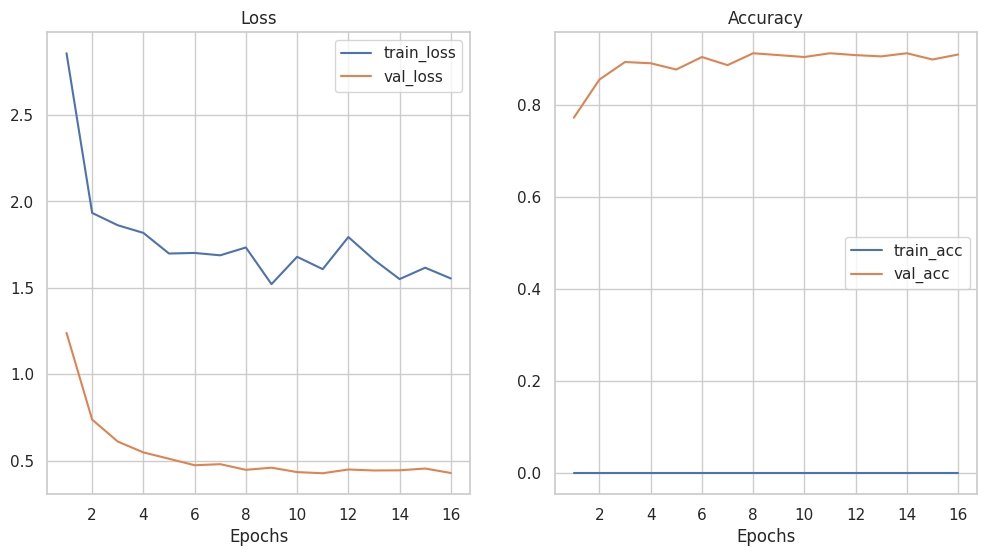

In [17]:
cutmixres = data_aug_extension(data_aug='CUTMIX')
create_graphs(cutmixres, 'extension_graphs/resnet_34cutmix')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmixres['val_res']])}")

In [18]:
# load best loss
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix.pth')

## Lets continue training but use unfreeze layer4

Epoch 1
-------------------------------


loss: 2.076626  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.80it/s]


Validation Error: 
 Accuracy: 90.2%, Avg loss: 0.519656 

Epoch 2
-------------------------------


loss: 1.629925  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.97it/s]


Validation Error: 
 Accuracy: 88.5%, Avg loss: 0.457401 

Epoch 3
-------------------------------


loss: 1.074422  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.92it/s]


Validation Error: 
 Accuracy: 89.3%, Avg loss: 0.452574 

Epoch 4
-------------------------------


loss: 1.899506  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.93it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.397407 

Epoch 5
-------------------------------


loss: 1.903508  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.95it/s]


Validation Error: 
 Accuracy: 90.1%, Avg loss: 0.433426 

Epoch 6
-------------------------------


loss: 0.380687  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.96it/s]


Validation Error: 
 Accuracy: 91.6%, Avg loss: 0.410078 

Epoch 7
-------------------------------


loss: 1.757838  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.01it/s]


Validation Error: 
 Accuracy: 92.7%, Avg loss: 0.320878 

Epoch 8
-------------------------------


loss: 1.191116  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.76it/s]


Validation Error: 
 Accuracy: 90.5%, Avg loss: 0.451687 

Epoch 9
-------------------------------


loss: 1.180327  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.80it/s]


Validation Error: 
 Accuracy: 90.6%, Avg loss: 0.370998 

Epoch 10
-------------------------------


loss: 1.456841  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.82it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.431595 

Epoch 11
-------------------------------


loss: 0.517719  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.90it/s]


Validation Error: 
 Accuracy: 92.4%, Avg loss: 0.407406 

Epoch 12
-------------------------------


loss: 1.719401  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.52it/s]


Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.402780 

Early stopping!
Training done!
Best achieved validation loss: 0.32087845776392065
Best achieved validation loss: 0.32087845776392065


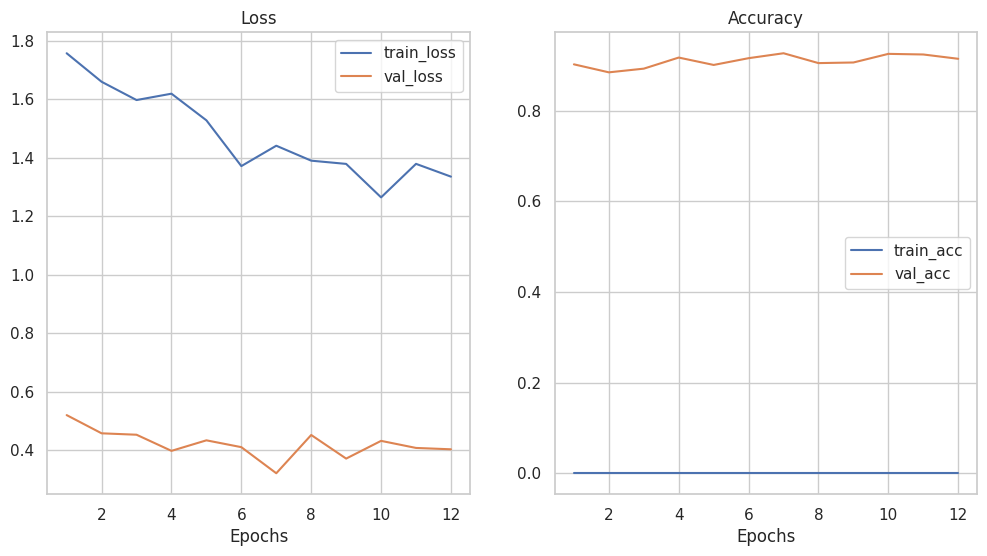

In [19]:


# load cutmix model
model.load_state_dict(torch.load('resnet34_cutmix.pth'))

# unfreeze layer 4
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-4},
    ], weight_decay=1e-4)

# train the model
cutmix_2 = data_aug_extension(model=model, data_aug='CUTMIX', optimizer=optimizer)
create_graphs(cutmix_2, 'extension_graphs/resnet_34cutmix2')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_2['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix2.pth')

Epoch 1
-------------------------------


loss: 0.469438  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.78it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.359599 

Epoch 2
-------------------------------


loss: 1.718805  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.70it/s]


Validation Error: 
 Accuracy: 90.6%, Avg loss: 0.363858 

Epoch 3
-------------------------------


loss: 2.017550  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.53it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.392881 

Epoch 4
-------------------------------


loss: 1.304414  Batch:[   91/   92]: 100%|██████████| 92/92 [00:27<00:00,  3.32it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.371878 

Epoch 5
-------------------------------


loss: 1.638370  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.65it/s]


Validation Error: 
 Accuracy: 90.9%, Avg loss: 0.431425 

Epoch 6
-------------------------------


loss: 1.281110  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.63it/s]


Validation Error: 
 Accuracy: 92.7%, Avg loss: 0.425914 

Epoch 7
-------------------------------


loss: 1.653761  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.72it/s]


Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.388636 

Epoch 8
-------------------------------


loss: 1.595327  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.93it/s]


Validation Error: 
 Accuracy: 91.6%, Avg loss: 0.439394 

Epoch 9
-------------------------------


loss: 1.482527  Batch:[   91/   92]: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s]


Validation Error: 
 Accuracy: 93.1%, Avg loss: 0.382774 

Epoch 10
-------------------------------


loss: 0.530152  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.82it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.467131 

Epoch 11
-------------------------------


loss: 0.871535  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.65it/s]


Validation Error: 
 Accuracy: 91.0%, Avg loss: 0.466258 

Epoch 12
-------------------------------


loss: 1.548775  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.71it/s]


Validation Error: 
 Accuracy: 92.0%, Avg loss: 0.418837 

Epoch 13
-------------------------------


loss: 1.511976  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.60it/s]


Validation Error: 
 Accuracy: 90.5%, Avg loss: 0.437157 

Epoch 14
-------------------------------


loss: 0.135469  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.60it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.359593 

Epoch 15
-------------------------------


loss: 0.308451  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.81it/s]


Validation Error: 
 Accuracy: 91.8%, Avg loss: 0.432941 

Epoch 16
-------------------------------


loss: 1.414248  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.04it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.456461 

Epoch 17
-------------------------------


loss: 1.250352  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.01it/s]


Validation Error: 
 Accuracy: 90.6%, Avg loss: 0.454561 

Epoch 18
-------------------------------


loss: 1.182161  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.05it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.423503 

Epoch 19
-------------------------------


loss: 1.460407  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.98it/s]


Validation Error: 
 Accuracy: 92.8%, Avg loss: 0.492885 

Early stopping!
Training done!
Best achieved validation loss: 0.35959300917127857
Best achieved validation loss: 0.35959300917127857


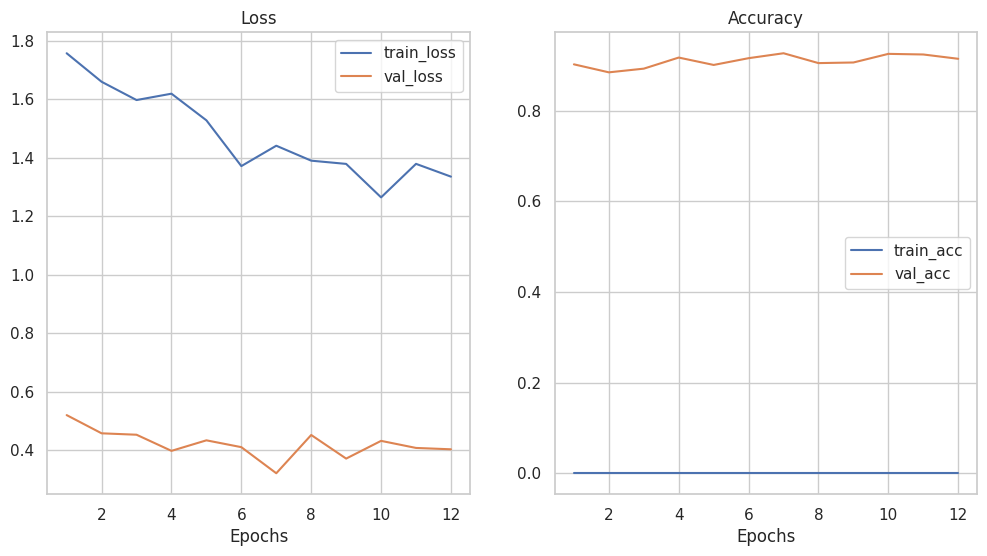

In [20]:

# load cutmix model
model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

# unfreeze layer 4
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-4},
    ], lr=1e-4, weight_decay=1e-4)

# train the model
cutmix_3 = data_aug_extension(model=model, data_aug='CUTMIX', optimizer=optimizer)
create_graphs(cutmix_3, 'extension_graphs/resnet_34cutmix3')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_3['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix3.pth')

Epoch 1
-------------------------------


loss: 1.103048  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.53it/s]


Validation Error: 
 Accuracy: 92.9%, Avg loss: 0.330888 

Epoch 2
-------------------------------


loss: 1.683984  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.65it/s]


Validation Error: 
 Accuracy: 92.7%, Avg loss: 0.328243 

Epoch 3
-------------------------------


loss: 0.528109  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.72it/s]


Validation Error: 
 Accuracy: 93.3%, Avg loss: 0.334069 

Epoch 4
-------------------------------


loss: 1.538085  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.66it/s]


Validation Error: 
 Accuracy: 93.2%, Avg loss: 0.322255 

Epoch 5
-------------------------------


loss: 1.559023  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.78it/s]


Validation Error: 
 Accuracy: 92.9%, Avg loss: 0.324677 

Epoch 6
-------------------------------


loss: 0.990316  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.85it/s]


Validation Error: 
 Accuracy: 92.7%, Avg loss: 0.340178 

Epoch 7
-------------------------------


loss: 1.278784  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.79it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.328695 

Epoch 8
-------------------------------


loss: 1.278970  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.82it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.323053 

Epoch 9
-------------------------------


loss: 1.230628  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.85it/s]


Validation Error: 
 Accuracy: 93.2%, Avg loss: 0.328674 

Early stopping!
Training done!
Best achieved validation loss: 0.32225537105746893
Best achieved validation loss: 0.32225537105746893


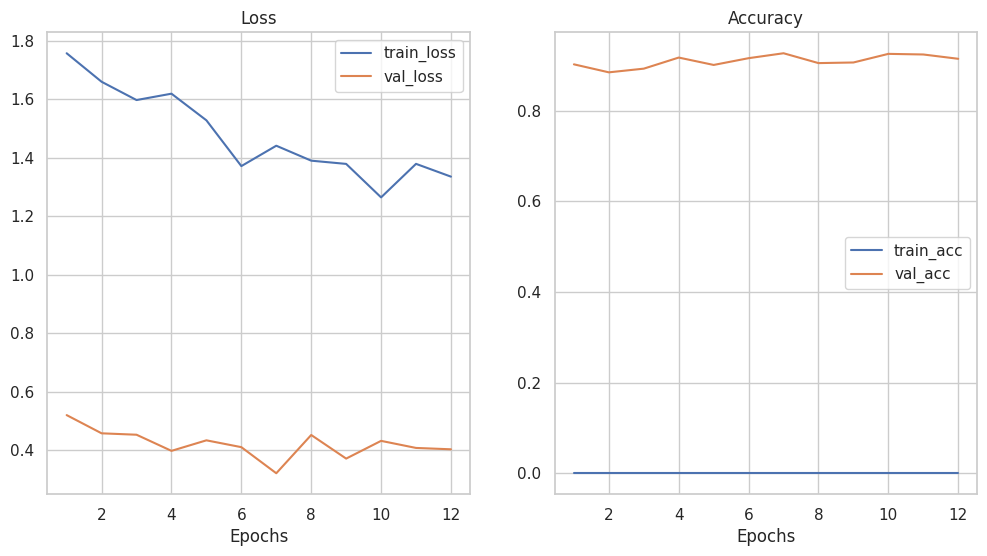

In [22]:
# repeat previous step but lets try freezing fc and layer4
# load cutmix model
model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

# unfreeze layer 4
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# train the model
cutmix_4= data_aug_extension(model=model, data_aug='CUTMIX', optimizer=optimizer)
create_graphs(cutmix_4, 'extension_graphs/resnet_34cutmix4')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_4['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix4.pth')

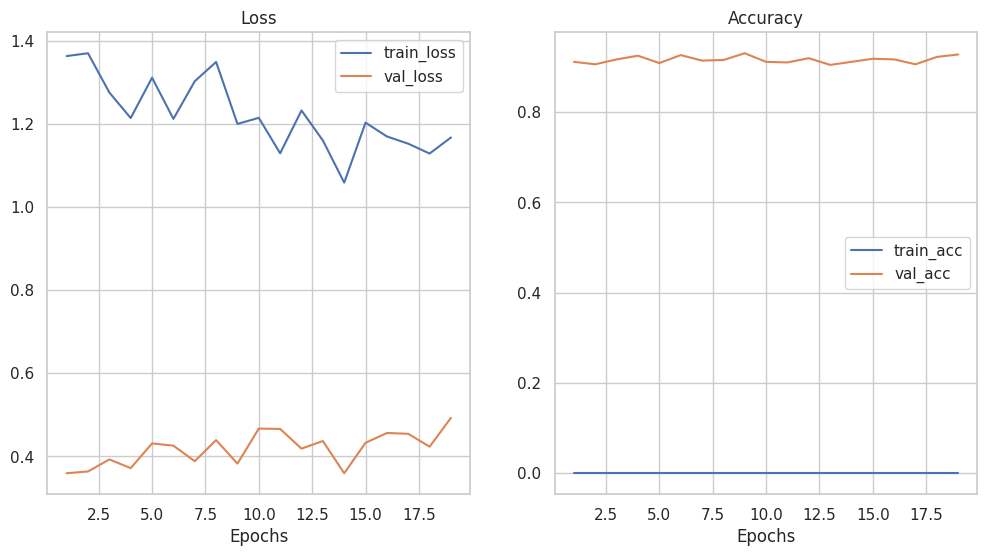

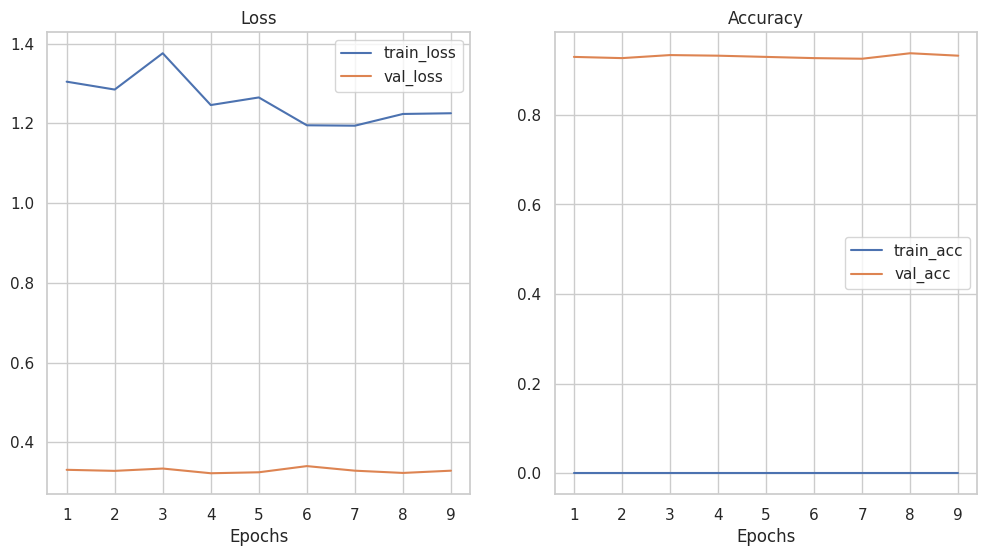

In [23]:
create_graphs(cutmix_3, 'extension_graphs/resnet_34cutmix3')
create_graphs(cutmix_4, 'extension_graphs/resnet_34cutmix4')


In [31]:
# load cutmix model

model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

for param in model.parameters():
    param.requires_grad = False
# unfreeze layer 4
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True



optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# train the model
cutmix_5 = data_aug_extension(model=model, data_aug='CUTMIX', optimizer=optimizer, scheduler=scheduler)
create_graphs(cutmix_5, 'extension_graphs/resnet_34cutmix5')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_5['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix5.pth')

Epoch 1
-------------------------------


loss: 1.732503  Batch:[    1/   92]:   8%|▊         | 7/92 [00:02<00:25,  3.27it/s]


KeyboardInterrupt: 

Epoch 1
-------------------------------


loss: 1.539068  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.87it/s]


Validation Error: 
 Accuracy: 90.5%, Avg loss: 0.401616 

Epoch 2
-------------------------------


loss: 1.711433  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.84it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.457666 

Epoch 3
-------------------------------


loss: 1.436269  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.56it/s]


Validation Error: 
 Accuracy: 89.8%, Avg loss: 0.422678 

Epoch 4
-------------------------------


loss: 0.799072  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.83it/s]


Validation Error: 
 Accuracy: 91.0%, Avg loss: 0.436250 

Epoch 5
-------------------------------


loss: 0.854259  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.86it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.420323 

Epoch 6
-------------------------------


loss: 1.530235  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.85it/s]


Validation Error: 
 Accuracy: 92.0%, Avg loss: 0.322411 

Epoch 7
-------------------------------


loss: 0.976964  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.88it/s]


Validation Error: 
 Accuracy: 90.2%, Avg loss: 0.469042 

Epoch 8
-------------------------------


loss: 0.471612  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.89it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.365085 

Epoch 9
-------------------------------


loss: 0.391461  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.90it/s]


Validation Error: 
 Accuracy: 91.8%, Avg loss: 0.397283 

Epoch 10
-------------------------------


loss: 1.369248  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.99it/s]


Validation Error: 
 Accuracy: 91.3%, Avg loss: 0.414266 

Epoch 11
-------------------------------


loss: 0.794787  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.12it/s]


Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.391708 

Early stopping!
Training done!
Best achieved validation loss: 0.3224109262228012
Best achieved validation loss: 0.3224109262228012


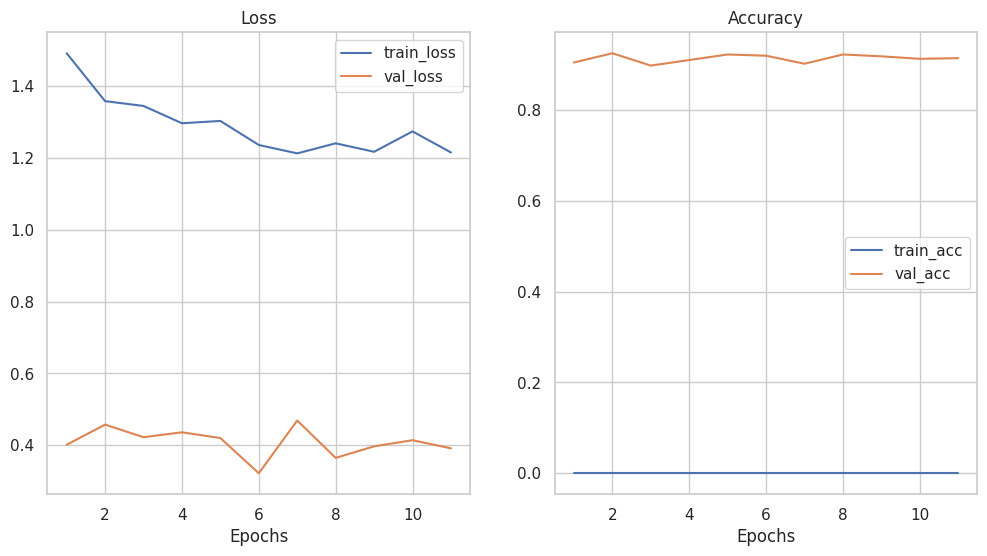

In [32]:
# load cutmix model

model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

for param in model.parameters():
    param.requires_grad = False
# unfreeze layer 4
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True



optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# train the model
cutmix_6 = data_aug_extension(model=model, data_aug='CUTMIX', optimizer=optimizer, scheduler=scheduler)
create_graphs(cutmix_6, 'extension_graphs/resnet_34cutmix7')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_6['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix6.pth')

Epoch 1
-------------------------------


loss: 3.357109  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.20it/s]


Validation Error: 
 Accuracy: 29.5%, Avg loss: 2.416127 

Epoch 2
-------------------------------


loss: 1.971115  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.14it/s]


Validation Error: 
 Accuracy: 68.9%, Avg loss: 1.054977 

Epoch 3
-------------------------------


loss: 0.746553  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.80it/s]


Validation Error: 
 Accuracy: 79.2%, Avg loss: 0.722397 

Epoch 4
-------------------------------


loss: 1.631821  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.78it/s]


Validation Error: 
 Accuracy: 80.4%, Avg loss: 0.745404 

Epoch 5
-------------------------------


loss: 1.141330  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.81it/s]


Validation Error: 
 Accuracy: 86.0%, Avg loss: 0.576259 

Epoch 6
-------------------------------


loss: 0.409699  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.89it/s]


Validation Error: 
 Accuracy: 86.1%, Avg loss: 0.483805 

Epoch 7
-------------------------------


loss: 1.838822  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.84it/s]


Validation Error: 
 Accuracy: 86.8%, Avg loss: 0.558695 

Epoch 8
-------------------------------


loss: 1.637654  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.83it/s]


Validation Error: 
 Accuracy: 88.3%, Avg loss: 0.437807 

Epoch 9
-------------------------------


loss: 1.723615  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.85it/s]


Validation Error: 
 Accuracy: 90.8%, Avg loss: 0.457760 

Epoch 10
-------------------------------


loss: 1.714965  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.87it/s]


Validation Error: 
 Accuracy: 91.3%, Avg loss: 0.468747 

Epoch 11
-------------------------------


loss: 1.921113  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  4.00it/s]


Validation Error: 
 Accuracy: 90.5%, Avg loss: 0.499539 

Epoch 12
-------------------------------


loss: 1.640520  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.11it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.430249 

Epoch 13
-------------------------------


loss: 1.627282  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.10it/s]


Validation Error: 
 Accuracy: 87.0%, Avg loss: 0.557876 

Epoch 14
-------------------------------


loss: 1.183576  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.22it/s]


Validation Error: 
 Accuracy: 89.0%, Avg loss: 0.472775 

Epoch 15
-------------------------------


loss: 2.215917  Batch:[   91/   92]: 100%|██████████| 92/92 [00:21<00:00,  4.25it/s]


Validation Error: 
 Accuracy: 89.5%, Avg loss: 0.530226 

Epoch 16
-------------------------------


loss: 1.786082  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.17it/s]


Validation Error: 
 Accuracy: 90.2%, Avg loss: 0.484666 

Epoch 17
-------------------------------


loss: 1.546061  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.13it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.477997 

Early stopping!
Training done!
Best achieved validation loss: 0.4302492122287336
Best achieved validation loss: 0.4302492122287336


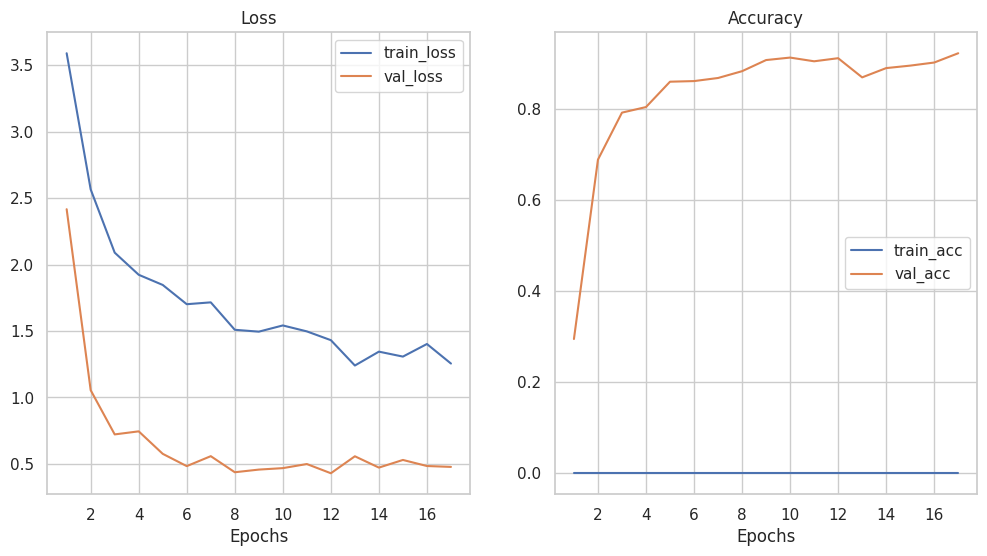

In [33]:
# load cutmix model

model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

for param in model.parameters():
    param.requires_grad = False
# unfreeze layer 4
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True



optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# train the model
cutmix_7 = data_aug_extension(model=model, data_aug='CUTMIX', optimizer=optimizer, scheduler=scheduler)
create_graphs(cutmix_7, 'extension_graphs/resnet_34cutmix7')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_7['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix7.pth')

Epoch 1
-------------------------------


loss: 1.604952  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.64it/s]


Validation Error: 
 Accuracy: 92.0%, Avg loss: 0.447913 

Epoch 2
-------------------------------


loss: 1.067233  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.25it/s]


Validation Error: 
 Accuracy: 90.1%, Avg loss: 0.490985 

Epoch 3
-------------------------------


loss: 1.463164  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.81it/s]


Validation Error: 
 Accuracy: 93.6%, Avg loss: 0.399469 

Epoch 4
-------------------------------


loss: 1.487130  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.01it/s]


Validation Error: 
 Accuracy: 92.1%, Avg loss: 0.385873 

Epoch 5
-------------------------------


loss: 1.394451  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.01it/s]


Validation Error: 
 Accuracy: 90.9%, Avg loss: 0.415097 

Epoch 6
-------------------------------


loss: 1.069226  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.04it/s]


Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.505984 

Epoch 7
-------------------------------


loss: 1.505483  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.99it/s]


Validation Error: 
 Accuracy: 91.3%, Avg loss: 0.399388 

Epoch 8
-------------------------------


loss: 1.452428  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.02it/s]


Validation Error: 
 Accuracy: 90.2%, Avg loss: 0.429977 

Epoch 9
-------------------------------


loss: 1.405905  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.98it/s]


Validation Error: 
 Accuracy: 91.8%, Avg loss: 0.362641 

Epoch 10
-------------------------------


loss: 0.606032  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.01it/s]


Validation Error: 
 Accuracy: 89.4%, Avg loss: 0.440322 

Epoch 11
-------------------------------


loss: 1.265214  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  4.00it/s]


Validation Error: 
 Accuracy: 91.0%, Avg loss: 0.445278 

Epoch 12
-------------------------------


loss: 1.406980  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.88it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.392472 

Epoch 13
-------------------------------


loss: 1.233201  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.94it/s]


Validation Error: 
 Accuracy: 91.6%, Avg loss: 0.411749 

Epoch 14
-------------------------------


loss: 0.633325  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.83it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.391052 

Epoch 15
-------------------------------


loss: 1.553367  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.64it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.381562 

Epoch 16
-------------------------------


loss: 1.242233  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.70it/s]


Validation Error: 
 Accuracy: 91.0%, Avg loss: 0.425561 

Epoch 17
-------------------------------


loss: 1.023346  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.69it/s]


Validation Error: 
 Accuracy: 91.4%, Avg loss: 0.450733 

Epoch 18
-------------------------------


loss: 1.463686  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.67it/s]


Validation Error: 
 Accuracy: 90.6%, Avg loss: 0.482398 

Epoch 19
-------------------------------


loss: 0.827495  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.71it/s]


Validation Error: 
 Accuracy: 92.7%, Avg loss: 0.439158 

Epoch 20
-------------------------------


loss: 1.394133  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.61it/s]


Validation Error: 
 Accuracy: 92.0%, Avg loss: 0.443287 

Epoch 21
-------------------------------


loss: 1.292238  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.74it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.483271 

Epoch 22
-------------------------------


loss: 1.131006  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.55it/s]


Validation Error: 
 Accuracy: 91.3%, Avg loss: 0.444774 

Epoch 23
-------------------------------


loss: 1.402002  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.48it/s]


Validation Error: 
 Accuracy: 91.8%, Avg loss: 0.442091 

Epoch 24
-------------------------------


loss: 1.503134  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.51it/s]


Validation Error: 
 Accuracy: 90.8%, Avg loss: 0.451614 

Epoch 25
-------------------------------


loss: 1.195159  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.80it/s]


Validation Error: 
 Accuracy: 90.4%, Avg loss: 0.382572 

Training done!
Best achieved validation loss: 0.3626412645630214
Best achieved validation loss: 0.3626412645630214


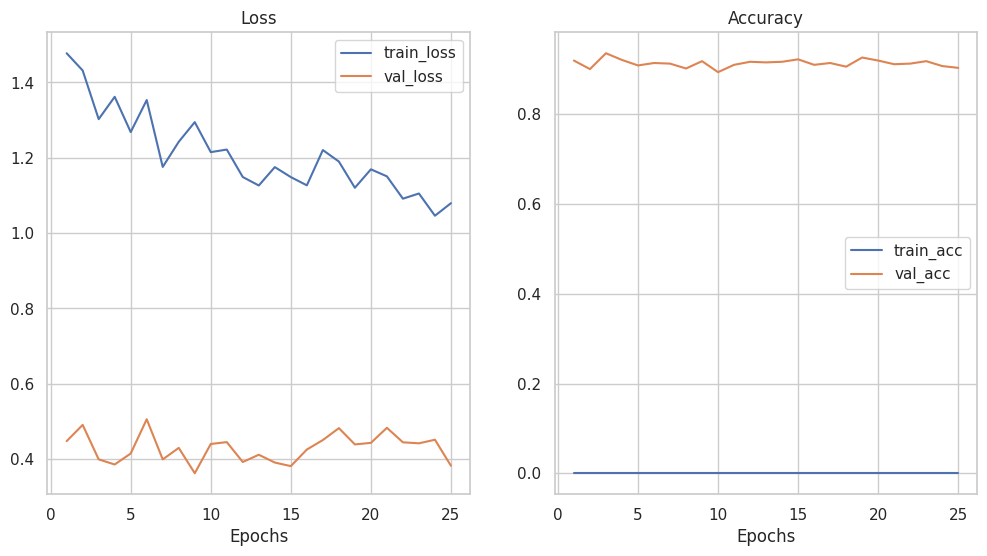

In [35]:

# load cutmix model
model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

# unfreeze layer 4
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-4},
    ], lr=1e-4, weight_decay=1e-4)

# train the model
cutmix_8 = data_aug_extension(model=model, data_aug='CUTMIX', optimizer=optimizer, patience=25)
create_graphs(cutmix_8, 'extension_graphs/resnet_34cutmix8')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_8['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix8.pth')

Epoch 1
-------------------------------


loss: 0.046787  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.04it/s]


Validation Error: 
 Accuracy: 90.5%, Avg loss: 0.266786 

Epoch 2
-------------------------------


loss: 0.001658  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.01it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.264222 

Epoch 3
-------------------------------


loss: 0.017152  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.46it/s]


Validation Error: 
 Accuracy: 86.8%, Avg loss: 0.457144 

Epoch 4
-------------------------------


loss: 0.000906  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.70it/s]


Validation Error: 
 Accuracy: 90.8%, Avg loss: 0.331256 

Epoch 5
-------------------------------


loss: 0.005142  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.82it/s]


Validation Error: 
 Accuracy: 91.6%, Avg loss: 0.340076 

Epoch 6
-------------------------------


loss: 0.010449  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.66it/s]


Validation Error: 
 Accuracy: 92.3%, Avg loss: 0.251831 

Epoch 7
-------------------------------


loss: 0.000740  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.80it/s]


Validation Error: 
 Accuracy: 93.6%, Avg loss: 0.238902 

Epoch 8
-------------------------------


loss: 0.000472  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.84it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.240887 

Epoch 9
-------------------------------


loss: 0.000045  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.84it/s]


Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.238977 

Epoch 10
-------------------------------


loss: 0.000046  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.98it/s]


Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.241120 

Epoch 11
-------------------------------


loss: 0.000129  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.99it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.243457 

Epoch 12
-------------------------------


loss: 0.000086  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.88it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.245685 

Epoch 13
-------------------------------


loss: 0.000039  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.86it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.248039 

Epoch 14
-------------------------------


loss: 0.000095  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.94it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.249807 

Epoch 15
-------------------------------


loss: 0.000033  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.91it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.251274 

Epoch 16
-------------------------------


loss: 0.000020  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.66it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.252959 

Epoch 17
-------------------------------


loss: 0.000043  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.79it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.254506 

Epoch 18
-------------------------------


loss: 0.000051  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.78it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.255754 

Epoch 19
-------------------------------


loss: 0.000032  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.84it/s]


Validation Error: 
 Accuracy: 94.3%, Avg loss: 0.256969 

Epoch 20
-------------------------------


loss: 0.000057  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.83it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.258211 

Epoch 21
-------------------------------


loss: 0.000041  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.94it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.259375 

Epoch 22
-------------------------------


loss: 0.000009  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.01it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.260438 

Epoch 23
-------------------------------


loss: 0.000017  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.85it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.261384 

Epoch 24
-------------------------------


loss: 0.000018  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.99it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.262427 

Epoch 25
-------------------------------


loss: 0.000014  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.06it/s]


Validation Error: 
 Accuracy: 94.3%, Avg loss: 0.263253 

Training done!
Best achieved validation loss: 0.23890163870933262
Best achieved validation loss: 0.23890163870933262
Epoch 1
-------------------------------


loss: 0.837705  Batch:[  111/  115]: 100%|██████████| 115/115 [00:28<00:00,  3.99it/s]


Validation Error: 
 Accuracy: 74.6%, Avg loss: 0.689910 

Training done!
Test Accuracy: 69.61%, Test loss: 0.8613415768127078


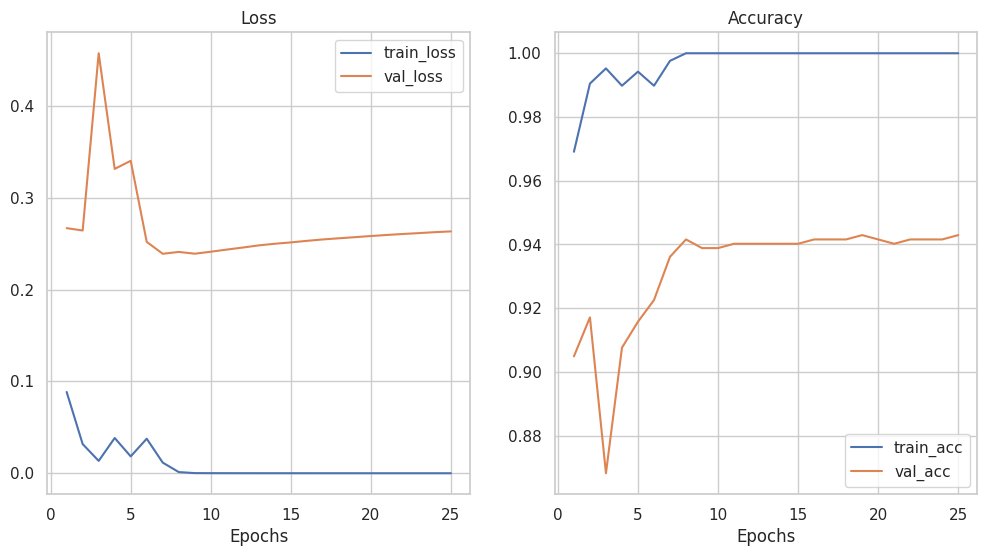

In [48]:
model = models.resnet34(weights='DEFAULT')
num_classes = 37
# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

# train the model
# load cutmix model
model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

for param in model.parameters():
    param.requires_grad = False


for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-4},
    ], lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# train the model
cutmix_9 = data_aug_extension(model=model, data_aug='DEFAULT', optimizer=optimizer, scheduler=scheduler, patience=25)

create_graphs(cutmix_9, 'extension_graphs/resnet_34cutmix9')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_9['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix9.pth')

# evaluation
# load cutmix model
model.load_state_dict(torch.load('best_model_loss.pth'))

# load in data from original dataset
train_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=resnet34_preprocess, download=True)
test_data = OxfordIIITPet(root='dataset', split='test', target_types='category', transform=resnet34_preprocess, download=True)

# dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# train for one epoch
results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, train_dataloader,
                      epochs=1, device=device, scheduler=scheduler, data_aug=False)


accuracy, test_loss = evaluate_model(test_dataloader, model, nn.CrossEntropyLoss(), device)

print(f"Test Accuracy: {accuracy:.2f}%, Test loss: {test_loss}")

Epoch 1
-------------------------------


loss: 0.015091  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.97it/s]


Validation Error: 
 Accuracy: 91.0%, Avg loss: 0.276073 

Epoch 2
-------------------------------


loss: 0.031905  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.92it/s]


Validation Error: 
 Accuracy: 91.3%, Avg loss: 0.365559 

Epoch 3
-------------------------------


loss: 0.004744  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.88it/s]


Validation Error: 
 Accuracy: 91.8%, Avg loss: 0.264683 

Epoch 4
-------------------------------


loss: 0.006851  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.86it/s]


Validation Error: 
 Accuracy: 89.1%, Avg loss: 0.410631 

Epoch 5
-------------------------------


loss: 0.006997  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.98it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.252283 

Epoch 6
-------------------------------


loss: 0.001891  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.83it/s]


Validation Error: 
 Accuracy: 92.7%, Avg loss: 0.215885 

Epoch 7
-------------------------------


loss: 0.000427  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Validation Error: 
 Accuracy: 92.4%, Avg loss: 0.235110 

Epoch 8
-------------------------------


loss: 0.000819  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.57it/s]


Validation Error: 
 Accuracy: 92.9%, Avg loss: 0.243570 

Epoch 9
-------------------------------


loss: 0.000919  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.56it/s]


Validation Error: 
 Accuracy: 93.6%, Avg loss: 0.218492 

Epoch 10
-------------------------------


loss: 0.000229  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.49it/s]


Validation Error: 
 Accuracy: 93.5%, Avg loss: 0.227397 

Epoch 11
-------------------------------


loss: 0.000076  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.56it/s]


Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.233084 

Epoch 12
-------------------------------


loss: 0.000055  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.56it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.236789 

Epoch 13
-------------------------------


loss: 0.000089  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.57it/s]


Validation Error: 
 Accuracy: 93.6%, Avg loss: 0.239657 

Epoch 14
-------------------------------


loss: 0.000105  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.61it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.242779 

Epoch 15
-------------------------------


loss: 0.000060  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.71it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.245165 

Epoch 16
-------------------------------


loss: 0.000094  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.94it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.247538 

Epoch 17
-------------------------------


loss: 0.000064  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.85it/s]


Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.249752 

Epoch 18
-------------------------------


loss: 0.000031  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.80it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.252275 

Epoch 19
-------------------------------


loss: 0.000058  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.79it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.254842 

Epoch 20
-------------------------------


loss: 0.000031  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.95it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.257502 

Epoch 21
-------------------------------


loss: 0.000020  Batch:[   91/   92]: 100%|██████████| 92/92 [00:28<00:00,  3.24it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.260749 

Epoch 22
-------------------------------


loss: 0.000008  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.75it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.264754 

Epoch 23
-------------------------------


loss: 0.000037  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.84it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.268942 

Epoch 24
-------------------------------


loss: 0.000011  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.69it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.274302 

Epoch 25
-------------------------------


loss: 0.000007  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.51it/s]


Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.278991 

Training done!
Best achieved validation loss: 0.21588462364414465
Best achieved validation loss: 0.21588462364414465
Epoch 1
-------------------------------


loss: 0.004116  Batch:[  111/  115]: 100%|██████████| 115/115 [00:29<00:00,  3.90it/s]


Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.045858 

Training done!
Test Accuracy: 89.15%, Test loss: 0.5481256507904302


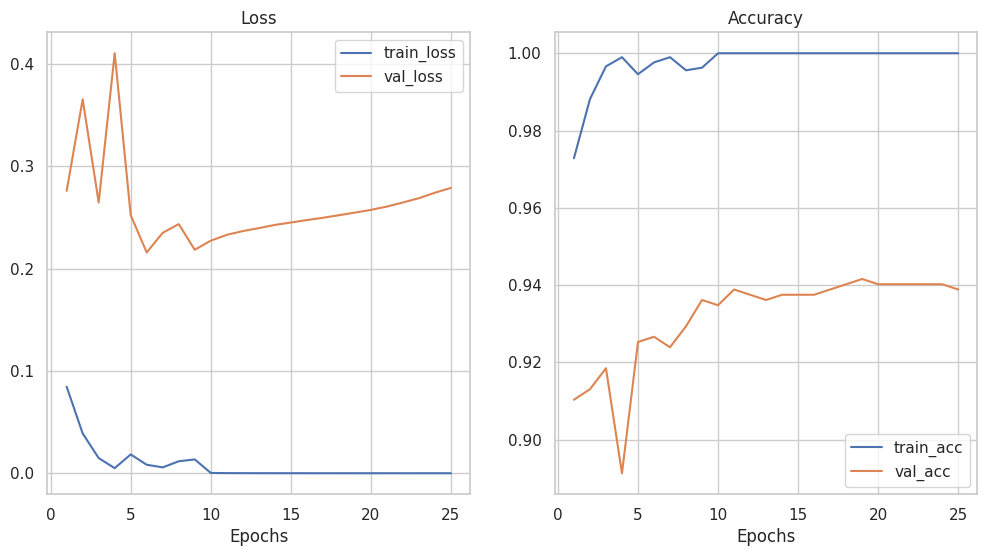

In [49]:
model = models.resnet34(weights='DEFAULT')
num_classes = 37
# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

# train the model
# load cutmix model
model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

for param in model.parameters():
    param.requires_grad = False


for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-4},
    ], lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# train the model
cutmix_10 = data_aug_extension(model=model, data_aug='DEFAULT', optimizer=optimizer, scheduler=scheduler, patience=25)

create_graphs(cutmix_10, 'extension_graphs/resnet_34cutmix10')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_10['val_res']])}")
model.load_state_dict(torch.load('best_model_acc.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix10.pth')

# evaluation
# load cutmix model
model.load_state_dict(torch.load('best_model_acc.pth'))

# load in data from original dataset
train_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=resnet34_preprocess, download=True)
test_data = OxfordIIITPet(root='dataset', split='test', target_types='category', transform=resnet34_preprocess, download=True)

# dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# train for one epoch
results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, train_dataloader,
                      epochs=1, device=device, scheduler=scheduler, data_aug=False)


accuracy, test_loss = evaluate_model(test_dataloader, model, nn.CrossEntropyLoss(), device)

print(f"Test Accuracy: {accuracy:.2f}%, Test loss: {test_loss}")

Epoch 1
-------------------------------


loss: 0.106789  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.03it/s]


Validation Error: 
 Accuracy: 91.2%, Avg loss: 0.275830 

Epoch 2
-------------------------------


loss: 0.121650  Batch:[   91/   92]: 100%|██████████| 92/92 [00:22<00:00,  4.02it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 0.269580 

Epoch 3
-------------------------------


loss: 0.003233  Batch:[   91/   92]: 100%|██████████| 92/92 [00:26<00:00,  3.44it/s]


Validation Error: 
 Accuracy: 90.9%, Avg loss: 0.280019 

Epoch 4
-------------------------------


loss: 0.000742  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.78it/s]


Validation Error: 
 Accuracy: 93.1%, Avg loss: 0.226832 

Epoch 5
-------------------------------


loss: 0.003741  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.74it/s]


Validation Error: 
 Accuracy: 92.1%, Avg loss: 0.253311 

Epoch 6
-------------------------------


loss: 0.001591  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.76it/s]


Validation Error: 
 Accuracy: 92.8%, Avg loss: 0.236336 

Epoch 7
-------------------------------


loss: 0.000347  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.75it/s]


Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.213449 

Epoch 8
-------------------------------


loss: 0.000064  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.72it/s]


Validation Error: 
 Accuracy: 93.5%, Avg loss: 0.219555 

Epoch 9
-------------------------------


loss: 0.000089  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.67it/s]


Validation Error: 
 Accuracy: 93.3%, Avg loss: 0.221386 

Epoch 10
-------------------------------


loss: 0.000076  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.71it/s]


Validation Error: 
 Accuracy: 93.5%, Avg loss: 0.224602 

Epoch 11
-------------------------------


loss: 0.000041  Batch:[   91/   92]: 100%|██████████| 92/92 [00:25<00:00,  3.56it/s]


Validation Error: 
 Accuracy: 93.5%, Avg loss: 0.227732 

Epoch 12
-------------------------------


loss: 0.000040  Batch:[   91/   92]: 100%|██████████| 92/92 [00:24<00:00,  3.70it/s]


Validation Error: 
 Accuracy: 93.5%, Avg loss: 0.229928 

Early stopping!
Training done!
Best achieved validation loss: 0.2134487687650582
Best achieved validation loss: 0.2134487687650582
Test Accuracy: 91.66%, Test loss: 0.3294224402831827


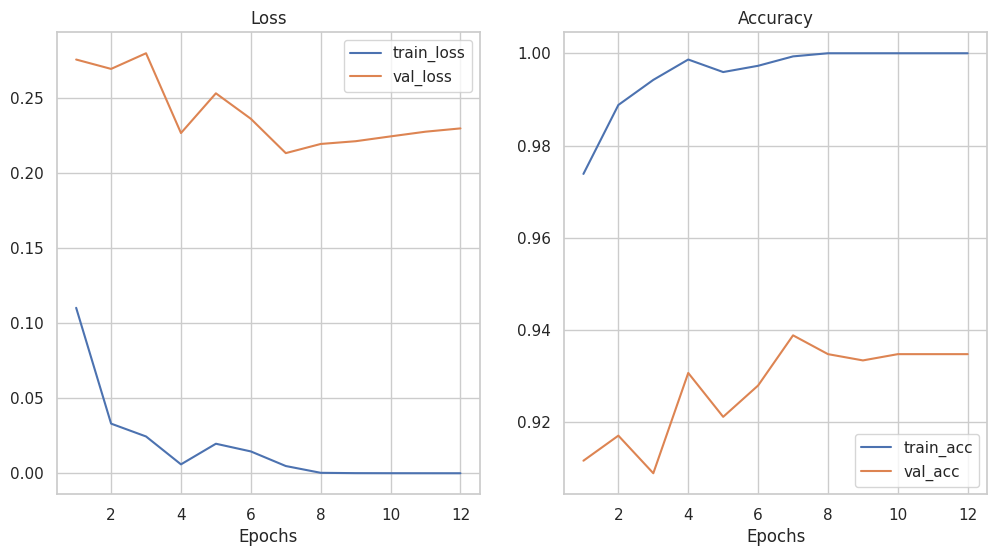

In [51]:
model = models.resnet34(weights='DEFAULT')
num_classes = 37
# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

# train the model
# load cutmix model
model.load_state_dict(torch.load('resnet34_cutmix2.pth'))

for param in model.parameters():
    param.requires_grad = False


for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam([
        {'params': model.layer4.parameters(), 'lr': 1e-4},
    ], lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# train the model
cutmix_11 = data_aug_extension(model=model, data_aug='DEFAULT', optimizer=optimizer, scheduler=scheduler, patience=5)

create_graphs(cutmix_11, 'extension_graphs/resnet_34cutmix11')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in cutmix_11['val_res']])}")
model.load_state_dict(torch.load('best_model_loss.pth'))
# save
torch.save(model.state_dict(), 'resnet34_cutmix11.pth')


accuracy, test_loss = evaluate_model(test_dataloader, model, nn.CrossEntropyLoss(), device)

print(f"Test Accuracy: {accuracy:.2f}%, Test loss: {test_loss}")

In [ ]:
def combine_results(dict1, dict2):
    train_loss = dict1['train_res']['train_loss'] + dict2['train_res']['train_loss']
    train_accuracy = dict1['train_res']['train_accuracy'] + dict2['train_res']['train_accuracy']
    validation_loss = dict1['val_res']['validation_loss'] + dict2['val_res']['validation_loss']
    validation_acc = dict1['val_res']['validation_acc'] + dict2['val_res']['validation_acc']

    return {'train_loss' : train_loss, 'train_accuracy': train_accuracy, 'validation_loss': validation_loss, 'validation_acc': validation_acc}


In [ ]:
# plot
combined_cutmix = combine_results(cutmixres, cutmix_2)
create_graphs(combined_cutmix, 'extension_graphs/resnet_34cutmix_combined')

combined_mixup = combine_results(mixupres, mixup_2)
create_graphs(combined_mixup, 'extension_graphs/resnet_34mixup_combined')

combined_random = combine_results(randomres, random_2)
create_graphs(combined_random, 'extension_graphs/resnet_34random_combined')

combined_randaug = combine_results(randaugres, randaug_2)
create_graphs(combined_randaug, 'extension_graphs/resnet_34randaug_combined')